# Introduction

I'm trying to find the best neighborhood in Pittsburgh based on **crime and Safety. Crime is a major dealbreaker and has an impact on how safe a neighborhood feels, how comfortable people are living there, and overall the quality of life. Because of that, total crime is a meaningful and straightforward way to compare different neighborhoods of the city.

So to measure safety, I used one of the crime data sets from the Western Pennsylvania Regional Data Center and analyzed all the reported crime incidents that occurred in 2024. My approach was really simple, as I just calculated the total number of crime reports in each neighborhood. The Neighborhoods with fewer incidents are considered safer, while neighborhoods with high incident counts are considered more dangerous.

This notebook walks through the steps I used to:
- load and clean the crime dataset,
- filter the data to the year 2024,
- count total incidents per neighborhood,
- and identify the safest and most dangerous neighborhoods based on those counts.




Using file: crime data.csv
Rows loaded: 69476
Columns: ['_id', 'Report_Number', 'ReportedDate', 'ReportedTime', 'Hour', 'DayofWeek', 'ReportedMonth', 'NIBRS_Coded_Offense', 'NIBRS_Offense_Code', 'NIBRS_Offense_Category', 'NIBRS_Offense_Type', 'NIBRS_Crime_Against', 'NIBRS_Offense_Grouping', 'Violation', 'XCOORD', 'YCOORD', 'Zone', 'Tract', 'Neighborhood', 'Block_Address']
Filtered to 2024: 61968 → 34580 rows

Top 10 MOST DANGEROUS neighborhoods (2024):

             neighborhood  crime_count
Central Business District         3680
         South Side Flats         2473
                  Carrick         1243
                Shadyside         1045
             East Liberty          985
               Bloomfield          887
           East Allegheny          883
         Mount Washington          790
                Knoxville          786
      Squirrel Hill South          771

Top 10 SAFEST neighborhoods (2024):

  neighborhood  safety_score
     Ridgemont      1.000000
   Saint Clair   

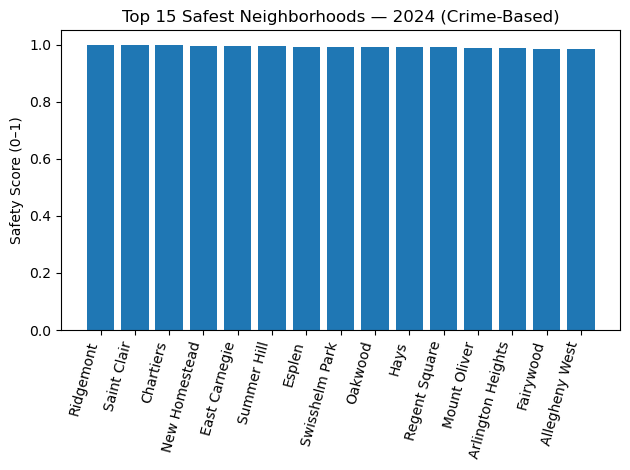

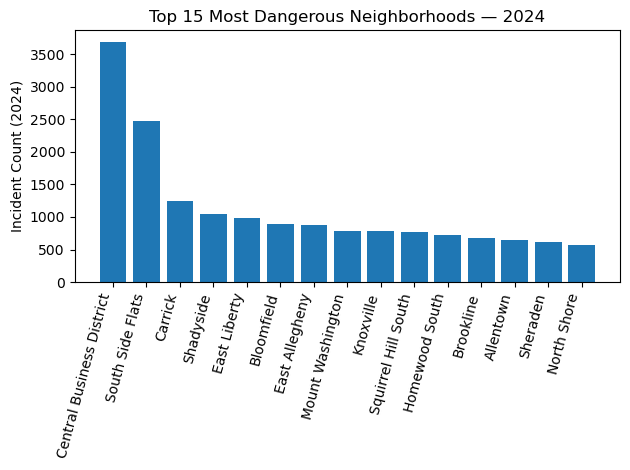


Saved:
 - data/processed/metric_crime.csv
 - data/processed/neighborhood_crime_totals.csv
 - data/processed/crime_ranked_with_score.csv


In [4]:
# === Crime → Safety sub-metric 

# Import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# We only want 2024 crime data
TARGET_YEAR = 2024

# Folder where files are stored
RAW_DIR = Path('.')
OUT_DIR = Path('data/processed')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Force the correct neighborhood column name to avoid confusion
FORCE_NEIGH_COL = "Neighborhood"

# 1. LOAD THE FILE
#  load YOUR file name exactly
src = RAW_DIR / "crime data.csv"
if not src.exists():
    raise FileNotFoundError("The file 'crime data.csv' is not in this folder.")

print("Using file:", src)

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(src, low_memory=False)
print("Rows loaded:", len(df))
print("Columns:", list(df.columns))

# 2. CLEAN THE DATA
# Use the neighborhood column you already have
neigh_col = FORCE_NEIGH_COL

# Remove rows where the neighborhood is missing
df = df.dropna(subset=[neigh_col]).copy()

# Standardize neighborhood names (capitalize properly)
df[neigh_col] = df[neigh_col].astype(str).str.strip().str.title()

# 3. EXTRACT YEAR FROM DATE COLUMNS

if "ReportedDate" in df.columns:
    df["ReportedDate"] = pd.to_datetime(df["ReportedDate"], errors="coerce")
    df["year"] = df["ReportedDate"].dt.year
elif "ReportedMonth" in df.columns:
    df["ReportedMonth"] = pd.to_datetime(df["ReportedMonth"], errors="coerce")
    df["year"] = df["ReportedMonth"].dt.year
else:
    raise KeyError("Your dataset does not contain date columns.")

# -----------------------------------------------
# 4. FILTER TO 2024
# -----------------------------------------------
before = len(df)
df = df[df["year"] == TARGET_YEAR].copy()
print(f"Filtered to {TARGET_YEAR}: {before} → {len(df)} rows")

if len(df) == 0:
    raise ValueError("No rows left after filtering to 2024.")


# 5. COUNT CRIMES PER NEIGHBORHOOD
totals = (
    df.groupby(neigh_col)
      .size()
      .reset_index(name="crime_count")
      .sort_values("crime_count", ascending=False)
      .reset_index(drop=True)
)

# Rename the column for convenience
totals.rename(columns={neigh_col: "neighborhood"}, inplace=True)

print("\nTop 10 MOST DANGEROUS neighborhoods (2024):\n")
print(totals.head(10).to_string(index=False))

# 6. CREATE A SAFETY SCORE (0–1, higher = safer)
# Explanation:
# - Neighborhood with the MOST crime gets a low score
# - Neighborhood with the LEAST crime gets a high score
def minmax_inverted(s: pd.Series) -> pd.Series:
    if s.max() == s.min():
        return pd.Series(0.5, index=s.index)  # If all same, neutral score
    return 1 - (s - s.min()) / (s.max() - s.min())

totals["safety_score"] = minmax_inverted(totals["crime_count"])

# Sorts the neighborhood by safety
ranked_safest = totals.sort_values("safety_score", ascending=False).reset_index(drop=True)
ranked_danger = totals.sort_values("crime_count", ascending=False).reset_index(drop=True)

print("\nTop 10 SAFEST neighborhoods (2024):\n")
print(ranked_safest.head(10)[["neighborhood", "safety_score"]].to_string(index=False))

# 7. VISUALIZE THE RESULTS

# Top 15 safest
plt.figure()
plt.bar(ranked_safest.head(15)["neighborhood"], ranked_safest.head(15)["safety_score"])
plt.xticks(rotation=75, ha='right')
plt.ylabel("Safety Score (0–1)")
plt.title("Top 15 Safest Neighborhoods — 2024 (Crime-Based)")
plt.tight_layout()
plt.show()

# Top 15 most dangerous
plt.figure()
plt.bar(ranked_danger.head(15)["neighborhood"], ranked_danger.head(15)["crime_count"])
plt.xticks(rotation=75, ha='right')
plt.ylabel("Incident Count (2024)")
plt.title("Top 15 Most Dangerous Neighborhoods — 2024")
plt.tight_layout()
plt.show()

# 8. SAVE OUTPUT FILES FOR GROUP COMBINATION
# 
# Safety score only (for group metric)
(ranked_safest[['neighborhood','safety_score']]
 .to_csv(OUT_DIR/'metric_crime.csv', index=False))

# Total crime counts
(totals[['neighborhood','crime_count']]
 .to_csv(OUT_DIR/'neighborhood_crime_totals.csv', index=False))

# Convenient combined file
(ranked_safest[['neighborhood','crime_count','safety_score']]
 .to_csv(OUT_DIR/'crime_ranked_with_score.csv', index=False))

print("\nSaved:")
print(" -", OUT_DIR/'metric_crime.csv')
print(" -", OUT_DIR/'neighborhood_crime_totals.csv')
print(" -", OUT_DIR/'crime_ranked_with_score.csv')



# Conclusion

Based on the total number of reported crime incidents in 2024, the neighborhoods that appear safest are **Ridgemont**, **Saint Clair**, and **Chartiers**. These areas  showed the lowest crime counts in the dataset, which suggests that they experience fewer disturbances and may offer a calmer and more secure environment compared to other parts of Pittsburgh.
